In [ ]:
import numpy as np
import cv2
from skimage.measure import label, regionprops


class Preprocess:
    def __init__(self, rawim, im, breast_mask, lesion_mask):
        self.raw = rawim
        self.image = im
        self.mask = breast_mask
        self.lesion_mask = lesion_mask
   
    def extract_breast_profile(image,lesion_mask, if_crop):
        
        breast_mask = np.zeros(np.shape(image))
        breast_mask[image>0]=1
        
        labelim = label(breast_mask)
        props =  regionprops(labelim)
#        find the largest object as the breast
        area = 0
        ind = 1
        for i in range(0,len(props)):
            if area<props[i].filled_area:
                area = props[i].filled_area
                ind = i+1
        breast_mask = np.zeros(np.shape(image))
        breast_mask[labelim==ind]=1  
        labelim = label(breast_mask)       
        props =  regionprops(labelim)
        boundingbox = props[0].bbox
#        crop the breast mask and mammogram
        if if_crop == 1:
            breast_mask = breast_mask[boundingbox[0]:boundingbox[2],boundingbox[1]:boundingbox[3]]
            breast_raw_image = image[boundingbox[0]:boundingbox[2],boundingbox[1]:boundingbox[3]]
            lesion_mask = lesion_mask[boundingbox[0]:boundingbox[2],boundingbox[1]:boundingbox[3]]
        else:
            breast_raw_image = image
#        breast_image = rescale2uint8(breast_raw_image,breast_mask)
        breast_image = rescale2uint16(breast_raw_image,breast_mask)
        return Preprocess(breast_raw_image,breast_image,breast_mask,lesion_mask)
    
def rescale2uint8(image,breast_mask):
    intensity_in_mask = image[breast_mask>0]
#    use top 0.2 percentile to do the strech
    maxi = np.percentile(intensity_in_mask,99.8)#np.max(intensity_in_mask)
    mini = np.percentile(intensity_in_mask,0.2)#np.min(intensity_in_mask)
#        stretch the image into 0~255
    
    image = 255*(image-mini)/(maxi-mini)
    image[breast_mask==0] = 0
    image[image<0] = 0
    image[image>255] = 255
    image = np.uint8(image)
          
    return image

def rescale2uint16(image,breast_mask):
    intensity_in_mask = image[breast_mask>0]
#    use top 0.2 percentile to do the strech
    maxi = np.percentile(intensity_in_mask,99.8)#np.max(intensity_in_mask)
    mini = np.percentile(intensity_in_mask,0.2)#np.min(intensity_in_mask)
#        stretch the image into 0~255
    
    image = 65535*(image-mini)/(maxi-mini)
    image[breast_mask==0] = 0
    image[image<0] = 0
    image[image>65535] = 65535
    image = np.uint16(image)
          
    return image


In [ ]:
import numpy as np
# To pad image into a square shape
def padimages(image,file_name, ratio):
    [length, width] = np.shape(image)
    if length/width>ratio:#1024/800
        print('This image needs padding.')
        add_wid = round(length*(1/ratio)-width)
        pad = np.zeros((length,add_wid))
        pad = pad.astype(image.dtype)
        if '_R_' in file_name:
        #                pad on the left
            pad_image = np.concatenate((pad,image),axis=1)
        else:
            pad_image = np.concatenate((image,pad),axis=1)
            
    return pad_image

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color, io, img_as_float

def mask_overlay(img, mask):
    alpha = 0.5

    img = img_as_float(img)
    rows, cols = img.shape
    # Construct RGB version of grey-level image
    img_color = np.dstack((img, img, img))
    img_hsv = color.rgb2hsv(img_color)
    color_mask = np.zeros((rows, cols, 3))
    color_mask1 = color_mask[:,:,1]
    color_mask1[np.where(mask>0)] = 1
    color_mask[:,:,1] = color_mask1
    color_mask_hsv = color.rgb2hsv(color_mask)
    
    # Replace the hue and saturation of the original image
    # with that of the color mask
    img_hsv[..., 0] = color_mask_hsv[..., 0]
    img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha
    
    img_masked = color.hsv2rgb(img_hsv)
    
    return img_masked

In [ ]:
cd '/content/drive/MyDrive/Mammographic/Mask_r_cnn'

/content/drive/MyDrive/Mammographic/Mask_r_cnn


In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Nov 26 15:46:32 2018

@author: Hang Min

Prepare the mammograms for pseudo-color transformation

To normalize the INbreast mammogram to 16bit

To pad the mammograms and masks to a square


"""



import os
import numpy as np
#from Preprocess_mammo import Preprocess 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
#from utility import padimages
#from skimage.segmentation import mark_boundaries
from skimage import io
from skimage.measure import label
#from overlay import mask_overlay
import timeit

start = timeit.default_timer()

import warnings
warnings.filterwarnings("ignore")

#from skimage import data, color, io, img_as_float

image_path = "scans/raw_mammogram/"
annotation_path = 'scans/raw_annotation/'

save_image_path = "scans/preprocessed_image/"   
if not os.path.exists(save_image_path):        
    os.mkdir(save_image_path)
 
    
save_mask_path = "scans/preprocessed_mask/"    
if not os.path.exists(save_mask_path):        
    os.mkdir(save_mask_path)


file_names = os.listdir(image_path)    
file_names = sorted(file_names)


for i in range(0,len(file_names)):

    print(file_names[i])
    mammo = io.imread(image_path+file_names[i],0)
   
    lesion_mask = io.imread(annotation_path+file_names[i])
    
    if np.max(lesion_mask)>=0:
#    Extract the breast profile and crop the mammogram, breast mask and the lesion mask
#    Normalize the image into 16-bit
        breast_preprocess = Preprocess.extract_breast_profile(mammo,lesion_mask,1)
               
        mammo = breast_preprocess.image
        breast_mask = breast_preprocess.mask
        lesion_mask =breast_preprocess.lesion_mask    
        
        print ('Number of lesions: '+str(np.max(np.unique(label(lesion_mask)))))
        
#   pad the image, to ensure the aspect ratio is 1:1
        pad_mammo = padimages(mammo,file_names[i],1)
        
#    save the preprocessed image

        io.imsave(save_image_path + file_names[i],pad_mammo)
        
        #if the image has more than 1 lesion, then seperate them into different masks and number them.
        
        labelim = label(lesion_mask)
        if np.max(labelim)>0:
#            if there is at least 1 lesion.
            for l in range(1,np.max(labelim+1)):
                l_mask = np.zeros(np.shape(labelim))
                l_mask = l_mask.astype(lesion_mask.dtype)
                l_mask [labelim==l] = 255
                num_nonzero = np.where(l_mask>0)
                num_nonzero = len(num_nonzero[0])

                if num_nonzero>15:
                    print('A valid mask')
#                   Pad the mask in the same way as padding the image
                    pad_l_mask = padimages(l_mask,file_names[i],1)
                    io.imsave(save_mask_path+file_names[i][:-4]+str(l)+'.png',pad_l_mask)
                else:
                    print('Has a tiny piece of noise that is not valid for training!')
                    
        else:# if there is no lesion
            pad_lesion_mask = padimages(lesion_mask,file_names[i],1)
            io.imsave(save_mask_path+file_names[i][:-4]+str(0)+'.png',pad_lesion_mask)
       
stop = timeit.default_timer()
print('RunTime per image: ', (stop - start)/ len(file_names)) 

In [ ]:
!pip install keras==2.1.5

In [ ]:
!pip install tensorflow==1.14.0
import tensorflow as tf
print(tf.__version__)

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN

In [ ]:
cd '/content/drive/MyDrive/Mammographic'

/content/drive/MyDrive/Mammographic


In [ ]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import matplotlib.image
import glob
import scipy.misc
from PIL import Image
#import imgaug 
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt
import imageio

In [ ]:
# Root directory of the project
ROOT_DIR = os.getcwd()
ROOT_DIR = ROOT_DIR+"/Mask_r_cnn"

MAMOGRAM_IMAGE_DIR = "/scans/pseudo_color_image/" #Path of the mammograms
MAMOGRAM_MASK_DIR = "/scans/preprocessed_mask/"# Path of the ground truth masks


# Import Mask RCNN
sys.path.append(ROOT_DIR) # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_balloon.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join("/content/drive/MyDrive/Mammographic", "logs")#Log directory for saving the weights
DEMO_SAVE_DIR = "/scans/seg_mask/"# path to save the segmentation masks

In [ ]:
############################################################
#  Configurations
############################################################


class MamogramConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "mamogram"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + lesion

    # Number of training steps per epoch,set to the number of training data here
    STEPS_PER_EPOCH = 5

    # Number of validation steps after each round of training
    VALIDATION_STEPS = 2
    # Resize mode: "none" or "square"

    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    # Skip detections with < DETECTION_MIN_CONFIDENCE
    DETECTION_MIN_CONFIDENCE = 0.965 # alter this during testing to generate different TPR at different FPI
    # 0.7 0.75 0.8 0.85 0.9

In [ ]:
############################################################
#  Dataset
############################################################

class MamogramDataset(utils.Dataset):

    def load_mamogram(self, subset):
        """This method loads the actual image
        subset is either "train" or "val" depending on whether the image is part of the training or validation datasets 
        """
        # Add classes. We have only one class to add.
        # These are the things that will be segmented
        self.add_class("mamogram", 1, "lesion")

        # Train or validation dataset?

        #list all the files in the directory with the mamogram images
        files = os.listdir(ROOT_DIR + MAMOGRAM_IMAGE_DIR + subset + "/")
        
        for fname in files:            
            self.add_image("mamogram", image_id=fname, 
                           path=ROOT_DIR + MAMOGRAM_IMAGE_DIR + subset +"/"+ fname, subset=subset, fname=fname)


    def load_mask(self, image_id):
        """load the instance masks for an image.
        Returns:
        a tuple containing:
        masks: A bool array of shape [height, width, instance count] with
        one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        use dtype=np.int32
        """
        image_info = self.image_info[image_id]
        info = self.image_info[image_id]
        fname = info['fname']
       
        files = glob.glob(ROOT_DIR + MAMOGRAM_MASK_DIR + info['subset']+"/" + fname[0:-4] + "*")
        

        masks = []
        for i in range(0, len(files)):
            #print(i)
            data = skimage.io.imread(files[i])
            
            if data.ndim != 1:
                data = skimage.color.rgb2gray(data)
          
            singleMask = data
            if i == 0:
                masks = np.zeros((singleMask.shape[0], singleMask.shape[1], len(files)))
            masks[:,:,i] = singleMask

        instanceMaskMap = np.array(np.ones([masks.shape[-1]], dtype=np.int32))
        
        return (masks.astype(np.bool), instanceMaskMap)


        #class_ids = np.array([self.class_names.index(s[0]) for s in fname])
        #return mask.astype(np.bool), class_ids.astype(np.int32)
         #this is VERY important: array of class ids in the order that they appear in bigdata
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1

    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
		Taken from utils.py, any refinements we need can be done here
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        return info["path"]

In [ ]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = MamogramDataset()
    dataset_train.load_mamogram("train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = MamogramDataset()
    dataset_val.load_mamogram("val")
    dataset_val.prepare()




    # Image augmentation
    # http://imgaug.readthedocs.io/en/latest/source/augmenters.html
    aug = iaa.Sequential([
        iaa.OneOf([iaa.Fliplr(0.5),
                   iaa.Flipud(0.5),
                   iaa.Affine(rotate=90),
                   iaa.Affine(rotate=180),
                   iaa.Affine(rotate=270)]),
    ])

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")

    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=3,augmentation=aug,
                layers='heads')

In [ ]:
def segment(model, imPath):
    
    image = skimage.io.imread(imPath)

    fname = imPath.split('/')[-1]
    mrcnnData = model.detect([image], verbose=1)
       # documentation for model.detect:
       # """Runs the detection pipeline.

       # images: List of images, potentially of different sizes.

       # Returns a list of dicts, one dict per image. The dict contains:
       # rois: [N, (y1, x1, y2, x2)] detection bounding boxes
       # class_ids: [N] int class IDs
       # scores: [N] float probability scores for the class IDs
       # masks: [H, W, N] instance binary masks
       # """

    mrcnnData = mrcnnData[0] #model.detect takes a list of images, but here we only provide one image so the output is a list with just one element

    masks = mrcnnData['masks']
    for i in range(0, masks.shape[2]):
        #iterate through the masks
        maskSingle = np.squeeze(masks[:, :, i])
        file_name =ROOT_DIR+ DEMO_SAVE_DIR + "demo_mask_" + str(i) + "_" + fname + "_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
        

        #scipy.misc.imsave(file_name, maskSingle.astype(np.int64))
        plt.imshow(maskSingle.astype(np.int8))
        #scipy.misc.imsave(file_name, maskSingle.astype(np.int64)) 
        matplotlib.image.imsave(file_name, maskSingle.astype(np.int64))
 


    print(mrcnnData)
    print("&&&&&&&&&&&: "+str(mrcnnData['rois']))
    print("&&&&&&&&&&&: "+str(mrcnnData['class_ids']))
    print("&&&&&&&&&&&: "+str(mrcnnData['scores']))

    return

def segmentWrapper(model, directory):
    """wrapper function for segment to take many images as an input, calls segment() on everything in the directory"""
    files = os.listdir(directory)
    for f in files:
        segment(model, directory + '/' + f)

def overlayResult(image, mask):
	"""Function to overlay segmentation mask on an image.
	usage: image_var = overlayResult(image, dict['masks'] || masks_var)
	
	image: RGB or grayscale image [height, width, 1 || 3].
	mask: segmentation mask [height, width, instance_count]
	
	returns resulting image.
	"""
	# Image is already in grayscale so we skip converting it
	# May need to create 3 dimensions if single dimension image though so
	# will add this as a placeholder
	gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
	# Copy color pixels from the original color image where mask is set
	if mask.shape[-1] > 0:
		#collapse masks into one layer
		mask = (np.sum(mask, -1, keepdims=True) >= 1)
		overlay = np.where(mask, image, gray).astype(np.uint8)
	else:
		overlay = gray.astype(np.uint8)
		
	return overlay

In [ ]:
 # Training dataset.
dataset_train = MamogramDataset()
dataset_train.load_mamogram("train")
dataset_train.prepare()

    # Validation dataset
dataset_val = MamogramDataset()
dataset_val.load_mamogram("val")
dataset_val.prepare()

In [ ]:
print(dataset_val.class_names)

['BG', 'lesion']


In [ ]:
config = MamogramConfig()

In [ ]:
model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)

In [ ]:
weights_path ='/content/drive/MyDrive/Mammographic/logs/mask_rcnn_mamogram_weights.h5'

In [ ]:
model.load_weights(weights_path, by_name=True)

In [ ]:
model = modellib.MaskRCNN(mode="training", config=config,model_dir=DEFAULT_LOGS_DIR)
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

Processing 1 images
image                    shape: (681, 681, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
{'rois': array([[267, 468, 324, 530]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9939551], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        

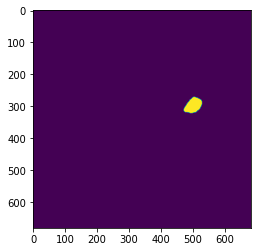

In [ ]:
segment(model, '/content/drive/MyDrive/Mammographic/Mask_r_cnn/scans/pseudo_color_image/22580192_5530d5782fc89dd7_MG_R_CC_ANON.png')

In [ ]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    masks, num_ids = dataset.load_mask(image_id)
    print(image,masks,num_ids)

In [ ]:
config = MamogramConfig()
#config.display()

model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)

weights_path = COCO_WEIGHTS_PATH


model.load_weights(weights_path, by_name=True)
train(model)

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/Mammographic/logs/mamogram20210327T1841/mask_rcnn_mamogram_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may du

Epoch 1/3
4/5 [=======================>......] - ETA: 1:14 - loss: 155.5872 - rpn_class_loss: 23.3238 - rpn_bbox_loss: 132.2633 - mrcnn_class_loss: 0.0000e+00 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


5/5 [==============================] - 432s 86s/step - loss: 154.4079 - rpn_class_loss: 22.1797 - rpn_bbox_loss: 132.2281 - mrcnn_class_loss: 0.0000e+00 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 276.1230 - val_rpn_class_loss: 15.1062 - val_rpn_bbox_loss: 261.0169 - val_mrcnn_class_loss: 0.0000e+00 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 2/3
5/5 [==============================] - 342s 68s/step - loss: 210.9497 - rpn_class_loss: 8.5504 - rpn_bbox_loss: 202.3993 - mrcnn_class_loss: 0.0000e+00 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 262.2912 - val_rpn_class_loss: 1.1692 - val_rpn_bbox_loss: 261.1220 - val_mrcnn_class_loss: 0.0000e+00 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 3/3
5/5 [==============================] - 340s 68s/step - loss: 247.8848 - rpn_class_loss: 0.4075 - rpn_bbox_loss: 247.4774 - mrcnn_class_loss: 2.3842e-08 - mrcnn_bbox_loss: 0.0000e+00 - mrcn

In [ ]:
!python mammo.py segment --weights=logs/mask_rcnn_mamogram_weights.h5 --image='/content/drive/MyDrive/Mammographic/Mask_r_cnn/scans/pseudo_color_image/22580192_5530d5782fc89dd7_MG_R_CC_ANON.png'

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [ ]:
!python mammo.py train --weights=mask_rcnn_balloon.h5

In [ ]:
config = MamogramConfig()
#config.display()

model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)

weights_path = COCO_WEIGHTS_PATH


model.load_weights(weights_path, by_name=True)
train(model)